In [1]:
### Run sementic segmentation model U-net with pretrained weights ###
import os
os.chdir('E:/BasW/Notebooks') 
work_directory = os.getcwd()
os.chdir(work_directory+'/Scripts')
from DataCreation import *
from DataPreprocessing import *
from DataAugmentation import *
from DataNormalization import *
from Unet import unet
import CreateResults as cr
import tensorflow
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as keras
os.chdir('../..') # --> ensures that work directory = E:/BasW/Notebooks
work_directory = "E:/BasW/Data"

Using TensorFlow backend.


Set variables and directories

In [2]:
# Set variables and path directories
image_size = (512, 512) 
cell_size = 0.25 
epsg = 28992    
# Create N2000_DataPreparation object
dp = N2000_DataPreparation(image_size = image_size)
dn = DataNormalization(image_size = (512,512))

Save training data as h5 file (optional)

In [4]:
#dp.SaveTrainingData(path_training_data = f"{work_directory}/H5130_Gelderland/training_data_rgb", name_file = '2016_Gelderland_Rgb.h5')
dp.SaveTrainingData(path_training_data = f"{work_directory}/H5130_Gelderland/CirRgb", name_file = '2016_Gelderland_CirRgb.h5')

Run the U-net convolutional neural network on unseen data

In [5]:
### Predictions of model X ###
json_path = work_directory + "/H5130_Gelderland/h5130_2016_Gelderland.json"
geotiff_folder = work_directory + "/H5130_Totaal/predictions/Run12"
model_path = work_directory + "/H5130_Totaal/checkpoints/JsonModels/h5130_run12.json"
model_weights = work_directory + "/H5130_Totaal/checkpoints/Run12_weights_best.h5"

# Open saved U-net model from json
json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
# Convert Json model to Tensorflow ConvNetmodel
loaded_model = model_from_json(loaded_model_json)
# Load weights into the model
loaded_model.load_weights(model_weights)
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Loaded model from disk


Predict images and plot predicted images (code on Azure)

In [6]:
# Make predictions and write prediction to geotiff
h5Path = f"{work_directory}/H5130_Gelderland/2016_Gelderland_CirRgb.h5"
images, masks, filenames = cr.readH5File(h5Path)
x_test = images
y_test = masks

In [7]:
# Normalize test dataset 
stats_file = work_directory + "/H5130_Totaal/training/Run12/2016_2017_2018_Totaal_NormalizationCirRgb.csv"
#x_test = dn.NormalizeDataPerBand(h5_file = h5Path, stats_file=stats_file, mask = False)
x_test = dn.NormalizeData(h5_file = h5Path, stats_file=stats_file, array_result = True)

In [8]:
print(x_test.shape, y_test.shape)
print(np.min(x_test), np.max(x_test), np.max(y_test))
print(len(filenames))

(1131, 512, 512, 4) (1131, 512, 512, 1)
4.6122193e-05 1.0000074 1.0
1131


4.6122193e-05 0.9058934


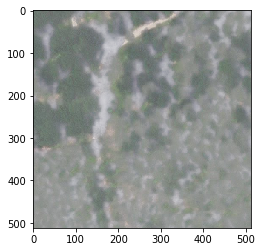

In [17]:
train_img = x_test[600]
mask_img = y_test[600]
print(np.min(train_img), np.max(train_img))
plt.imshow(train_img)
plt.show()


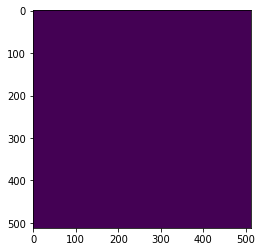

In [18]:
mask_img = mask_img.reshape(512,512)
plt.imshow(mask_img)
plt.show()

In [19]:
mask_img.shape

(512, 512)

In [20]:
for i in range(len(x_test)):
    j = i+1
    image = x_test[i:j]
    filename = filenames[i:j][0]
    prediction = loaded_model.predict(image, batch_size = 6)
    prediction = np.squeeze(prediction, axis = 0)
    cr.writeGeoTiff(json_path, prediction, filename, geotiff_folder)

In [ ]:
geotiff_folder = work_directory + "/H5130_Totaal/predictions/Run12"
#cr.vectorizePrediction(geotiff_folder, cat = 'bgt_gras_prob90', prob_treshold = 0.9)
#cr.vectorizePrediction(geotiff_folder, cat = 'bgt_gras_prob75', prob_treshold = 0.75)
#cr.vectorizePrediction(geotiff_folder, cat = 'bgt_gras6channels_prob25', prob_treshold = 0.25)
cr.vectorizePrediction(geotiff_folder, cat = 'H5130_CirRgb_161718_prob50', prob_treshold = 0.50)

In [ ]:
# SHOW RESULTS ON TEST SET --> OUD --> NOT GEOTIFF
import scipy
predictions = loaded_model.predict(x_test, batch_size = 4)
predictions = predictions[0:20]

for i in range(len(predictions)):
    pred =  predictions[i].reshape(512,512)
    img = x_test[i]
    gt = y_test[i].reshape(512,512)

    scipy.misc.imsave(geotiff_folder + '/Test_img_' +str(i)+".tif", img)
    scipy.misc.imsave(geotiff_folder + '/Test_gt_' + str(i)+".tif", gt)
    scipy.misc.imsave(geotiff_folder + '/Test_prediction_'+str(i)+".tif", pred)